# LWE Cryptosystem

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from itertools import product
from scipy.stats import norm
from math import log, sqrt, pi, log

from sage.stats.distributions.discrete_gaussian_integer import DiscreteGaussianDistributionIntegerSampler

## Auxiliary functions

In [2]:
def print_combined_matrix_with_separator(A, P, separator='|'):
    """
    Prints the combined matrix of A and P with a visual separator between them.

    A: Matrix on the left.
    P: Matrix on the right.
    separator: The separator symbol, default is '|'.
    """
    combined_matrix_str = ''
    for i in range(A.nrows()):
        # Combine rows of A and P with separator in between
        combined_row = ' '.join(map(str, A[i, :])) + ' ' + separator + ' ' + ' '.join(map(str, P[i, :]))
        combined_matrix_str += combined_row + '\n'

    print(combined_matrix_str)
    
# Function to read and print the content of a file
def print_file_content(file_path):
    with open(file_path, "r") as file:
        print(file.read())
        
        
def count_elements_efficient(lst):
    count_dict = {}

    for element in lst:
        if element in count_dict:
            count_dict[element] += 1
        else:
            count_dict[element] = 1

    return count_dict



        
def center_lift(pol): #Centra els coeficients del polinomi entrat per parametre a [-q/2, q/2].

    return pol.lift().map_coefficients(lambda c: c.lift_centered(), ZZ) 

##### Special Auxiliar Functions

Here we have the
* **Statistical Distance Function**
* **Babai's Algorithm**

In [119]:
def calculate_statistical_distance(prob_x, prob_y, q):
    # Initialize statistical distance
    distance = 0

    # Calculate the range of possible values
    range_of_values = range(-q//2, q//2 + 1)

    # Sum the absolute differences of the probabilities
    for value in range_of_values:
        # Calculate the probability for each value in prob_x and prob_y
        # If a value is not present in the dictionary, default to 0
        p_x = prob_x.get(value, 0) / sum(prob_x.values())
        p_y = prob_y.get(value, 0) / sum(prob_y.values())

        # Add the absolute difference to the distance
        distance += abs(p_x - p_y)

    # Divide the accumulated distance by 2
    distance /= 2

    return float(distance)


def babais_nearest_plane(self, lattice_basis, target_matrix):
    # The lattice_basis is assumed to be already LLL-reduced.

    # Solve the system lattice_basis * t = target_matrix to find the coefficients.
    # Since lattice_basis is LLL-reduced and forms a basis, we can use the solve_right method.
    t_coefficients = lattice_basis.solve_right(target_matrix)
    # Round the coefficients to the nearest integers to get a_i's.
    a_coefficients = t_coefficients.apply_map(lambda x: round(x))

    # Compute the vector v as a linear combination of lattice_basis vectors with the rounded coefficients.
    v = lattice_basis * a_coefficients

    return v % self.q

## Learning With Errors (LWE) Cryptosystem Analysis

This section provides an extensive analysis and demonstration of the Learning With Errors (LWE) cryptosystem. The section is divided into three main parts:

### Part 1: LWE Cryptosystem Basic Demonstration

#### Key Activities:
- **Initialization**: Setting up an LWE instance with predefined parameters.
- **Key Generation**: Generating both private and public keys.
- **Encryption and Decryption**: Encrypting a predefined message and then decrypting it back to verify the correctness of the cryptosystem.

```python
lwe = LWE(n=5, m=2, l=10, t=4, r=5, q=101, alpha=0.02)
lwe.gen_keys()
# Encryption and decryption code follows

```

### Part 2: LWE File Encryption and Decryption
#### Key Activities:
- **Setting** Up a New LWE Instance: Creating an LWE instance with a different set of parameters.
- **File Encryption**: Encrypting the contents of a text file and saving the results in a separate file.
- **File Decryption:** Decrypting the encrypted file content and saving it, allowing for a comparison between the original and decrypted content.
```python
lwe = LWE(n=6, m=3, l=8, t=2, r=4, q=103, alpha=0.03)
lwe.encrypt_file("message.txt", "encrypted.txt")
lwe.decrypt_file("encrypted.txt", "decrypted.txt")
```

### Part 3: Performance Analysis
#### Key Activities:
- **Performance Measurement:** Analyzing how the encryption and decryption times vary with different values of the parameter n.
- **Plotting Performance Metrics:** Creating a graph to visualize the relationship between n and the average encryption/decryption times.

In [120]:
class LWE:
    """
    A class representing a Learning With Errors (LWE) cryptosystem.
    """
    
    # Parameters of cryptosystem
    n :int = None
    m :int = None
    l :int = None
    t :int = None
    r :int = None
    q :int = None
    alpha :float = None
        
    # Elements of the Cryptosystem
    S: Matrix = None  # Private key matrix
    A: Matrix = None  # Public key matrix A
    P: Matrix = None  # Public key matrix P
    
    #Auxiliar elements
    _error_sampler: DiscreteGaussianDistributionIntegerSampler = None # Sampler for error terms in the cryptosystem
    
    
    
    def __init__(self, n, m, l, t, r, q, alpha): 
        """Initializes the LWE class with given parameters."""
        self.n = n
        self.m = m
        self.l = l
        self.t = t
        self.r = r
        self.q = q
        self.alpha = alpha
        
        self._error_sampler = DiscreteGaussianDistributionIntegerSampler(sigma=(self.alpha * self.q) / sqrt(2*pi))        
    
    def _function_f(self, message):
        """
        Maps a message vector from Z_t^l to Z_q^l.

        message: The message vector in Z_t^l.
        Returns: The mapped message vector in Z_q^l.
        """
        # Scale factor
        scale = self.q / self.t

        # Apply the mapping: multiply by scale and round to nearest integer
        # Use SageMath's vector operations for this
        mapped_message = vector(ZZ, [round(scale * m_i) for m_i in message])

        # Ensure the result is in Z_q^l
        # SageMath vectors support modulo operation directly
        mapped_message = mapped_message % self.q

        return mapped_message
    
    def _function_f_inv(self, mapped_message):
        """
        The reverse mapping of _function_f.

        mapped_message: The mapped message vector in Z_q^l.
        Returns: The original message vector in Z_t^l.
        """
        # Scale factor
        inv_scale = self.t / self.q

        # Apply the mapping: multiply by scale and round to nearest integer
        # Use SageMath's vector operations for this
        original_message = vector(ZZ, [round(inv_scale * m_i) for m_i in mapped_message])

        # Ensure the result is in Z_q^l
        # SageMath vectors support modulo operation directly
        original_message = original_message % self.t

        return original_message        
    

    def gen_priv_key(self, private_key=None):
        """
        Generates or sets the private key for the LWE cryptosystem.

        private_key: (Optional) A Matrix to set as the private key.
        Returns: The generated or set private key matrix.
        """
        # If a private key is provided, check its dimensions and values
        if private_key is not None:
            if isinstance(private_key, Matrix) and \
               private_key.nrows() == self.n and \
               private_key.ncols() == self.l and \
               all(0 <= entry < self.q for entry in private_key.list()):
                self.S = private_key
            else:
                raise ValueError("Provided private key has incorrect dimensions or values out of range.")
        else:
            # Generate the private key S as an n x l matrix with entries in Z_q
            self.S = Matrix(ZZ, self.n, self.l, [randint(0, self.q-1) for elem in range(self.n*self.l)])
        
        return self.S


    def gen_pub_key(self, public_key_A=None):
        """
        Generates or sets the public key for the LWE cryptosystem.

        public_key_A: (Optional) A Matrix to set as part of the public key.
        Returns: The generated or set public key matrices A and P.
        """
        # Check if public_key_A is provided
        if public_key_A is not None:
            if (isinstance(public_key_A, Matrix) and
                public_key_A.nrows() == self.m and
                public_key_A.ncols() == self.n):
                self.A = public_key_A
            else:
                raise ValueError("Provided public key A has incorrect dimensions or values out of range.")


        else:
            # If A is not provided, generate both A and P
            self.A = Matrix(ZZ, self.m, self.n, [randint(0, self.q-1) for _ in range(self.m*self.n)])

            
        # Use the provided private key or generate a new one
        if self.S is None:
            self.gen_priv_key()

        # Generate the error matrix E as an m x l matrix with a Gaussian distribution
        # Here we assume a simple uniform distribution for the error terms for simplicity.
        E = Matrix(ZZ, self.m, self.l, [self._error_sampler() for _ in range(self.m*self.l)])

        # Compute the public matrix P as A * S + E
        self.P = (self.A * self.S + E) % self.q
        
        return self.A, self.P
        
        
        
    def gen_keys(self, private_key=None, public_key_A=None): 
        """
        Generates both private and public keys of the LWE cryptosystem.

        private_key: (Optional) A Matrix to set as the private key.
        public_key_A: (Optional) A Matrix to set as part of the public key.
        """
        # Generate private and public keys
        self.gen_priv_key(private_key=private_key)
        self.gen_pub_key(public_key_A=public_key_A)
            
     
    def encryption(self, message):
        """
        Encrypts a message using the LWE cryptosystem.

        message: The message to be encrypted.
        Returns: The encrypted message as a tuple (u, c).
        """
        try:
            assert len(message) == self.l  # Ensure the message has the correct length
            
        except AssertionError: 
            print(f'Message is not of length {self.l}')            
        
        # Generate a random binary vector r of length m
        a = vector(ZZ, [randint(-self.r, self.r) for _ in range(self.m)])

        # Compute the ciphertext u = A^T * a (mod q)
        u = (a * self.A ) % self.q
        
        # Compute the ciphertext c = r * P + m (mod q)
        c = (a * self.P + self._function_f(vector(ZZ, message))) % self.q

        return u, c
        
        
    def decryption(self, encrypted_message): 
        """
        Decrypts an encrypted message using the LWE cryptosystem.

        encrypted_message: A tuple (u, c) representing the encrypted message.
        Returns: The decrypted message.
        """
        u = vector(ZZ, encrypted_message[0])
        
        c = vector(ZZ, encrypted_message[1])

        return self._function_f_inv(c - u*self.S)
    
    def encrypt_file(self, m_filename, e_filename):
        """
        Encrypts the content of a file line by line and writes the encrypted data to another file.

        m_filename: Filename of the input file containing plaintext.
        e_filename: Filename of the output file to write encrypted data.
        """
        write_lines_list = []
        
        with open(m_filename, "r") as f:
            lines_list = f.read().splitlines()
        
        for line in lines_list:
            # Convert the line to its binary representation
            m_bits = np.unpackbits(np.frombuffer(line.encode(), dtype=np.uint8))

            # Process the binary representation in chunks of length l
            line_encrypted_str = ""
            for i in range(0, len(m_bits), self.l):
                chunk = m_bits[i:i+self.l]
                
                # Pad the last chunk if necessary
                if len(chunk) < self.l:
                    chunk = np.concatenate([chunk, np.zeros(self.l - len(chunk), dtype=np.uint8)])

                # Encrypt the chunk
                u, c = self.encryption(list(chunk))

                # Convert encrypted data to a string format and accumulate
                line_encrypted_str += " ".join(map(str, u)) + " " + " ".join(map(str, c)) + " "

            # Append the accumulated encrypted string for the line
            write_lines_list.append(line_encrypted_str.strip() + "\n")

        # Write the encrypted lines to the output file
        with open(e_filename, "w") as f:
            f.writelines(write_lines_list)


    
    
    def decrypt_file(self, e_filename, d_filename):
        """
        Decrypts the content of an encrypted file and writes the decrypted data to another file.

        e_filename: Filename of the input file containing encrypted data.
        d_filename: Filename of the output file to write decrypted plaintext.
        """
        decrypted_lines_list = []

        with open(e_filename, "r") as f:
            encrypted_lines_list = f.read().splitlines()

        for encrypted_line in encrypted_lines_list:
            # Split the encrypted line into chunks
            encrypted_chunks = encrypted_line.split(" ")
            decrypted_bits = np.array([], dtype=np.uint8)

            for i in range(0, len(encrypted_chunks), self.n + self.l):
                # Extract each chunk's u and c
                u = list(map(int, encrypted_chunks[i:i + self.n]))
                c = list(map(int, encrypted_chunks[i + self.n:i + self.n + self.l]))

                # Decrypt the chunk
                decrypted_chunk = self.decryption((u, c))
                decrypted_bits = np.concatenate([decrypted_bits, decrypted_chunk])

            # Convert the binary message back to text
            decrypted_line = np.packbits(decrypted_bits).tobytes().decode('utf-8', errors='ignore')
            decrypted_lines_list.append(decrypted_line)

        with open(d_filename, "w") as f:
            f.writelines([line + "\n" for line in decrypted_lines_list])

    
    def get_priv_key(self): 
        """
        Returns the private key of the LWE cryptosystem. If the private key has not been generated, it generates one.

        new_h: A parameter (currently unused) for setting the public key.
        Returns: The private key matrix.
        """
        # Generate the private key if not already done
        if self.S is None:
            self.gen_priv_keys()
        return Matrix(ZZ, self.S)
    
    def get_pub_key(self): 
        """
        Returns the public key of the LWE cryptosystem. If the public key has not been generated, it generates one.

        Returns: The public key matrices A and P.
        """
        # Generate the public key if not already done
        if self.A is None or self.P is None:
            self.gen_pub_key()
        return Matrix(ZZ,self.A), Matrix(ZZ,self.P)
        
    def print_parameters(self):
        """
        Prints the parameters of the LWE cryptosystem and their current values.
        """
        print("Cryptosystem Parameters:")
        print(f"n (dimension): {self.n}")
        print(f"m (number of samples): {self.m}")
        print(f"l (message length): {self.l}")
        print(f"t (modulus for message space): {self.t}")
        print(f"r (range for error sampling): {self.r}")
        print(f"q (modulus for ciphertext): {self.q}")
        print(f"alpha (error rate): {self.alpha}")
        
    def print_sizes_and_error_probability(self):
        """
        Prints the sizes of the private key, public key, message, and ciphertext in bits,
        and calculates the probability of error for a letter.
        """
        # Sizes in bits
        private_key_size = self.n * self.l * log(self.q, 2)
        public_key_size = self.m * (self.n + self.l) * log(self.q, 2)
        message_size = self.l * log(self.t, 2)
        ciphertext_size = (self.n + self.l) * log(self.q, 2)

        print("Sizes (in bits):")
        print(f"Private key size: {private_key_size}")
        print(f"Public key size: {public_key_size}")
        print(f"Message size: {message_size}")
        print(f"Ciphertext size: {ciphertext_size}")

        # Error probability
        error_prob = 2 * (1 - norm.cdf(1 / (2 * self.t * self.alpha) * sqrt(6 * pi / (self.r * (self.r + 1) * self.m))))
        print(f"Probability of error for a letter: {error_prob}")


### Part 1: LWE Cryptosystem Example 1

In this example/demostration, we illustrate the usage of the Learning With Errors (LWE) cryptosystem:

1. **Initialization**: Create an LWE instance with specific parameters (dimension, samples, message length, modulus, range, and error rate).

    ```python
    lwe = LWE(n=5, m=2, l=10, t=4, r=5, q=101, alpha=0.02)
    ```

2. **Key Generation**: Generate both the private and public keys for the LWE cryptosystem.

    ```python
    lwe.gen_keys()
    ```

3. **Display Parameters and Keys**: Print the LWE parameters, the private key (`S`), and the public key (`A`, `P`).

4. **Encryption**: Encrypt a predefined message.

    ```python
    message = [1, 1, 1, 2, 2, 3, 3, 3, 0, 0]
    ciphertext = lwe.encryption(message)
    ```

5. **Decryption**: Decrypt the ciphertext to retrieve the original message.

    ```python
    decryption = lwe.decryption(ciphertext)
    ```

This process showcases the core functionalities of LWE, including key management, message encryption, and decryption.


In [5]:
# Initialize the LWE instance with specified parameters
lwe = LWE(n=5, m=8, l=10, t=4, r=5, q=101, alpha=0.02)

# Generate the keys
lwe.gen_keys()

# 1. Print the parameters of the LWE cryptosystem
lwe.print_parameters()
print("------")

# 2. Display the private key
print("Private Key (S):")
print(lwe.S)
print("------")

# 3. Display the public key
print("Public Key (A, P):")
print_combined_matrix_with_separator(lwe.A, lwe.P)


print("------")

# 4. Show the relation between A, S, P
print("Relation (A * S) % q - P:")
print((lwe.A * lwe.S) % lwe.q - lwe.P)
print("------")

# 5. Define and encrypt the message
message = [1, 1, 1, 2, 2, 3, 3, 3, 0, 0]
print("Original Message:")
print(message)
print("------")

ciphertext = lwe.encryption(message)
print("Encrypted Message (ciphertext):")
print(ciphertext)
print("------")

# 6. Decrypt the message
decryption = lwe.decryption(ciphertext)
print("Decrypted Message:")
print(decryption)
print("------")

# 7. Print the LWE cryptosystem properties
lwe.print_sizes_and_error_probability()



Cryptosystem Parameters:
n (dimension): 5
m (number of samples): 8
l (message length): 10
t (modulus for message space): 4
r (range for error sampling): 5
q (modulus for ciphertext): 101
alpha (error rate): 0.0200000000000000
------
Private Key (S):
[ 13  15  45  85  86   8  47  69  57  51]
[ 28  13  94  24  70  73  70  15  36  79]
[ 59  20  12  76  36  99  99  25  22  11]
[ 73  43 100  55  11  68  76  92  51  36]
[ 61  41  21  16  62  29  59  47  35  88]
------
Public Key (A, P):
(5, 81, 62, 51, 13) | (3, 45, 17, 94, 3, 79, 22, 30, 47, 15)
(49, 45, 38, 46, 57) | (67, 33, 64, 62, 47, 0, 15, 98, 97, 13)
(87, 21, 39, 39, 66) | (86, 75, 28, 26, 29, 52, 17, 45, 65, 0)
(39, 92, 53, 13, 91) | (85, 61, 8, 5, 15, 42, 82, 62, 44, 34)
(29, 61, 61, 33, 6) | (77, 73, 86, 72, 100, 14, 92, 83, 14, 100)
(86, 1, 78, 25, 51) | (78, 70, 89, 100, 76, 47, 78, 72, 18, 4)
(73, 26, 70, 72, 6) | (17, 14, 58, 46, 67, 37, 29, 43, 15, 72)
(2, 98, 70, 34, 54) | (51, 16, 31, 72, 42, 99, 59, 35, 19, 45)

------
Rel

### Part 2: LWE File Encryption and Decryption Example 2

In this example, we demonstrate file encryption and decryption using a different set of parameters for the LWE cryptosystem:

1. **Create LWE Instance with New Parameters**: Initialize an LWE instance with a new set of parameters.

    ```python
    lwe = LWE(n=6, m=3, l=8, t=2, r=4, q=103, alpha=0.03)
    ```

2. **Key Generation**: Generate keys for the cryptosystem.

    ```python
    lwe.gen_keys()
    ```

3. **File Encryption**: Encrypt the contents of `message.txt` and save the encrypted data in `encrypted.txt`.

    ```python
    lwe.encrypt_file("message.txt", "encrypted.txt")
    ```

4. **File Decryption**: Decrypt the contents of `encrypted.txt` and save the decrypted data in `decrypted.txt`.

    ```python
    lwe.decrypt_file("encrypted.txt", "decrypted.txt")
    ```

5. **Print Cryptosystem Parameters and Sizes**: Display the parameters and calculated sizes of keys, messages, and ciphertexts.

    ```python
    lwe.print_parameters()
    lwe.print_sizes_and_error_probability()
    ```

6. **Display File Contents**:

    - **Original Message File (`message.txt`)**:
        ```python
        with open("message.txt", "r") as file:
            print(file.read())
        ```

    - **Encrypted File (`encrypted.txt`)**:
        ```python
        with open("encrypted.txt", "r") as file:
            print(file.read())
        ```

    - **Decrypted File (`decrypted.txt`)**:
        ```python
        with open("decrypted.txt", "r") as file:
            print(file.read())
        ```

This process shows the encryption and decryption capabilities of the LWE cryptosystem with files, providing a clear demonstration from the original message to the encrypted content and back to the decrypted message.


In [6]:
# Initialize the LWE instance with new parameters
lwe = LWE(n=15, m=12, l=8, t=2, r=4, q=1327, alpha=0.025)

# Generate the keys
lwe.gen_keys()

# Encrypt the file
lwe.encrypt_file("message.txt", "encrypted.txt")

# Decrypt the file
lwe.decrypt_file("encrypted.txt", "decrypted.txt")

# Display the contents of the original, encrypted, and decrypted files
print("Original Message (message.txt):")
print_file_content("message.txt")
print("------")

print("Encrypted Message (encrypted.txt):")
print_file_content("encrypted.txt")
print("------")

print("Decrypted Message (decrypted.txt):")
print_file_content("decrypted.txt")

Original Message (message.txt):
The LWE problem was introduced by Oded Regev in 2005 (who won the 2018 Godel Prize for this work).
Regev showed that the LWE problem is as hard to solve as several worst-case lattice problems.
It is based on the idea of representing secret information as a set of equations with errors.
In other words, LWE is a way to hide the value of a secret by introducing noise to it.
------
Encrypted Message (encrypted.txt):
392 1295 995 497 347 289 214 139 466 420 1040 1186 178 973 1234 483 781 591 406 921 680 884 592 1148 1193 1152 525 1307 247 1069 584 1154 917 235 334 409 51 768 925 795 238 1135 29 1314 184 430 1100 210 882 408 1187 711 125 1246 493 555 1081 795 717 1303 1010 32 93 976 904 555 175 580 784 1098 390 477 908 980 768 619 464 85 1079 363 109 701 502 276 730 28 365 96 0 316 1176 211 614 839 586 480 868 292 446 104 194 236 1285 499 659 515 1244 952 67 741 1305 60 458 213 1034 1272 139 353 37 900 1 126 675 658 1039 406 457 635 214 265 1187 275 1263 47 96

### Part 3: Analyzing LWE Cryptosystem Performance
In the following code block, we analyze how the encryption and decryption times in an LWE cryptosystem vary with different values of the parameter n. This analysis helps in understanding the computational complexity and scalability of the cryptosystem.

* We vary n from 1 to 30 and keep other parameters realtive to the dimension in use.
* For each value of n, we perform 100 encryption and decryption trials to average out the time taken.
* Finally, we plot these average times to visualize the performance trend.

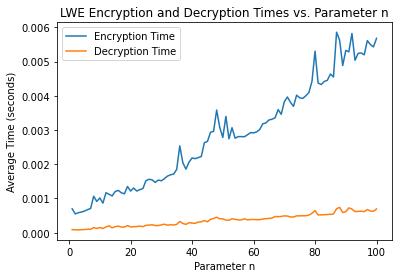

In [747]:
import time

# Define a range for 'n'
n_values = range(1, 101)  # Adjust the range as needed
num_attempts = 20

# Initialize lists to store average times
encryption_times = []
decryption_times = []

for n in n_values:
    total_encryption_time = 0
    total_decryption_time = 0

    for _ in range(num_attempts):
        # Initialize LWE with the current 'n' and other fixed parameters
        m_value = int(((lwe.n+lwe.l)*log(lwe.q, 2) + 200)/log(2*lwe.r +1))
        lwe = LWE(n=n, m=m_value, l=n, t=2, r=3, q=101, alpha=0.1)
        lwe.gen_keys()
        message = [1] * lwe.l  # A sample message

        # Time encryption
        start_time = time.time()
        ciphertext = lwe.encryption(message)
        end_time = time.time()
        total_encryption_time += (end_time - start_time)

        # Time decryption
        start_time = time.time()
        lwe.decryption(ciphertext)
        end_time = time.time()
        total_decryption_time += (end_time - start_time)

    # Compute average times
    avg_encryption_time = total_encryption_time / num_attempts
    avg_decryption_time = total_decryption_time / num_attempts

    encryption_times.append(avg_encryption_time)
    decryption_times.append(avg_decryption_time)

# Plotting
plt.plot(n_values, encryption_times, label='Encryption Time')
plt.plot(n_values, decryption_times, label='Decryption Time')
plt.xlabel('Parameter n')
plt.ylabel('Average Time (seconds)')
plt.title('LWE Encryption and Decryption Times vs. Parameter n')
plt.legend()
plt.show()


## Attack Learning With Errors 1: Brute-Force


## Brute Force Attack on Learning With Errors (LWE) Cryptosystem

This notebook presents the implementation of a brute force attack on the Learning With Errors (LWE) cryptosystem. The `BruteForce` class encapsulates the necessary components and methods for this attack.

### Class Description: `BruteForce`

#### Cryptosystem Parameters

- `n`: The dimension parameter of the LWE problem.
- `m`: The number of samples used in the LWE problem.
- `l`: The length of the secret vector.
- `t`: The modulus for the message space.
- `r`: The range for error sampling.
- `q`: The modulus for the ciphertext.
- `alpha`: The error rate used in the cryptosystem.

#### Cryptosystem Elements

- `lwe`: An instance of the LWE class representing the cryptosystem.
- `S`: The private key matrix.
- `A`: The public key matrix A.
- `P`: The public key matrix P.
- `G`: A guess vector used in the brute force attack.

#### Auxiliary Elements

- `_error_sampler`: A sampler for generating discrete Gaussian distributed error terms in the cryptosystem.

### Initialization

The `BruteForce` class is initialized with the LWE parameters and immediately generates the keys for the LWE cryptosystem.

### Methods

#### `_generate_all_possible_private_keys_vectors()`

This method generates all possible vectors for private keys within the range 0 to `q-1`. Each vector is yielded as a matrix for compatibility with SageMath's matrix operations.

#### `obtain_priv_keys()`

This method attempts to guess the private key based on statistical distance. It performs the following steps:

1. **Gaussian Sampler**: It uses an error sampler to generate a large number of Gaussian values. These values are used to create a probability distribution which serves as a reference for the brute force attack.

2. **Initialization**: Initializes the best guess for the private key and its corresponding distance for each element of the private key.

3. **Brute Force Guessing**: 
   - Iterates over all possible private key vectors.
   - For each guess, it performs necessary matrix operations to transform the guess into a format that can be compared against the Gaussian distribution.
   - Transforms values to be within the range \(-\frac{q}{2}\) to \(\frac{q}{2}\) to match the modular arithmetic nature of LWE.
   - Computes the statistical distance between the transformed guess and the Gaussian distribution.
   - Keeps track of the guess that has the smallest distance for each element of the private key.

4. **Result**: 
   - The guesses with the smallest distances are combined into a single matrix, which is the final guessed private key.
   - This guessed key is returned as the result of the brute force attack.

### Usage

To use the `BruteForce` class, instantiate it with appropriate LWE parameters and then call the `obtain_priv_keys` method to perform the attack. The method returns a matrix which is the guessed private key. This can be compared with the actual private key to verify the success of the brute force attack.

```python
bruteforce_instance = BruteForce(n=2, m=700, l=8, t=4, r=5, q=101, alpha=0.1)
private_key_guess = bruteforce_instance.obtain_priv_keys()
private_key_real = bruteforce_instance.S

# Compare the guessed key with the actual key
print("Guessed Private Key:")
print(private_key_guess)
print("------")
print("Real Private Key:")
print(private_key_real)
```

This approach demonstrates a fundamental method in cryptanalysis, although its practicality is limited by the computational complexity inherent in brute force attacks, especially for large parameter sizes.


In [173]:
class BruteForce:
    """

    """
    
    # Parameters of cryptosystem
    n :int = None
    m :int = None
    l :int = None
    t :int = None
    r :int = None
    q :int = None
    alpha :float = None
        
    # Elements of the Cryptosystem
    lwe: LWE = None
    S: Matrix = None  # Private key matrix
    A: Matrix = None  # Public key matrix A
    P: Matrix = None  # Public key matrix P
    G: Matrix = None  # Guess Vector
    
    #Auxiliar elements
    _error_sampler: DiscreteGaussianDistributionIntegerSampler = None # Sampler for error terms in the cryptosystem
    
    
    
    def __init__(self, n, m, l, t, r, q, alpha): 
        """Initializes the LWE class with given parameters."""
        self.n = int(n)
        self.m = int(m)
        self.l = int(l)
        self.t = int(t)
        self.r = int(r)
        self.q = int(q)
        self.alpha = float(alpha)
        self.lwe = LWE(n, m, l, t, r, q, alpha)
        self.lwe.gen_keys()
        
        self.S = self.lwe.get_priv_key()
        self.A, self.P = self.lwe.get_pub_key()
        
        self._error_sampler = DiscreteGaussianDistributionIntegerSampler(sigma=(self.alpha * self.q) / sqrt(2*pi))   
        
    def _generate_all_possible_private_keys_vectors(self):
        """
        Generate all possible vectors for private keys within the range 0 to q-1.
        """

        # Create a range of values from 0 to q-1
        value_range = range(self.q)

        for vector in product(value_range, repeat=self.n):
            yield Matrix(ZZ, vector)

    
    def obtain_priv_keys(self):
        """
        This method attempts to guess the private key based on statistical distance.
        """

        # Assuming error_sampler is a callable that has been properly defined elsewhere in the class
        gaussian_values = vector(ZZ, [error_sampler() for _ in range(1000000)])
        gaussian_prob = count_elements_efficient(gaussian_values)
        
        # Initialize the best guess and its distance for each element of the private key
        private_key_guess = [0] * self.l
        distance_of_guess = [float('inf')] * self.l
        
        # Generate all possible private key vectors
        for guess_vector in self._generate_all_possible_private_keys_vectors():
            
            for i in range(0, self.l):
                # Convert guess_vector to a column vector and perform matrix multiplication
                guess_matrix = matrix(ZZ, guess_vector).transpose()
                product = (self.A * guess_matrix) % self.q

                # Extract the ith row of self.P as a column vector
                P_col = self.P.column(i)

                # Ensure both operands are column vectors of the same size
                transformed_guess_matrix = (matrix(ZZ, P_col) - matrix(ZZ, product).T) % self.q   
                
                # Transform values to be within -q/2 to q/2
                q_half = self.q // 2
                transformed_guess_list = [(value if value <= q_half else value - self.q) for value in (transformed_guess_matrix[0, i] for i in range(transformed_guess_matrix.ncols()))]
                private_key_prob = count_elements_efficient(transformed_guess_list)
                
                dist = calculate_statistical_distance(gaussian_prob, private_key_prob, self.q)
                
                if dist < distance_of_guess[i]:
                    distance_of_guess[i] = dist
                    private_key_guess[i] = guess_vector
                    
        # Convert the list of matrices to a single matrix
        private_key_guess_matrix = block_matrix([[m] for m in private_key_guess], subdivide=False).T

                    
        return private_key_guess_matrix     
        
        
        

In this example/demostration, we illustrate the usage of the BruteForce Attack to Learning With Errors (LWE) cryptosystem:

In [174]:
#We first define the BruteForce class to intantiate the LWE class inside it
bruteforce_instance = BruteForce(n=2, m=700, l=8, t=4, r=5, q=101, alpha=0.1)

#Perform the attack to get the private key and get the real private key stored
private_key_guess = bruteforce_instance.obtain_priv_keys()
private_key_real = bruteforce_instance.S

# Print the formatted guess and the actual private key
print("Guessed Private Key:")
print(private_key_guess)
print("Real Private Key:")
print(private_key_real)

# Check if the guessed private key is the same as the real private key
if private_key_guess == private_key_real:
    print("Success: The guessed private key matches the real private key.")
else:
    print("Failure: The guessed private key does not match the real private key.")




Guessed Private Key:
[44 34 61 98  1  0  1 27]
[17 99 94 33 71 68 50 62]
Real Private Key:
[44 34 61 98  1  0  1 27]
[17 99 94 33 71 68 50 62]
Success: The guessed private key matches the real private key.


#### Analyzing BruteForce Attack Cryptosystem Performance
In the following code block, we analyze how the performance of the BruteForce attack on the Learning With Errors (LWE) cryptosystem varies with different values of the parameter `n`. We focus on understanding how changes in `n`, which typically represents the dimensionality of the problem, affect the time taken to perform the brute force attack.

We vary `n` from 1 to 5 and measure the average time taken to guess the private key using the brute force method. This measurement is crucial as it provides insights into the computational complexity and feasibility of the brute force approach against LWE-based cryptosystems. A longer time indicates increased difficulty in breaking the encryption, suggesting stronger security for larger values of `n`. As we will see, attacks to `n` greater than 5 seems to be not optimal.

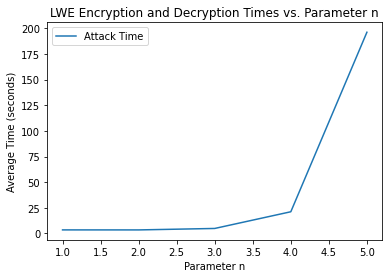

In [182]:
import time

# Define a range for 'n'
n_values = range(1, 6)  # Adjust the range as needed
num_attempts = 1

# Initialize lists to store average times
brute_force_attack_times = []

for n in n_values:
    total_attack_time = 0

    for _ in range(num_attempts):
        # Initialize LWE with the current 'n' and other fixed parameters
        bf = BruteForce(n=n, m=500, l=1, t=2, r=3, q=11, alpha=0.1)

        # Time attack
        start_time = time.time()
        private_key = bf.obtain_priv_keys()
        end_time = time.time()
        total_attack_time += (end_time - start_time)


    # Compute average times
    avg_attack_time = total_attack_time / num_attempts

    brute_force_attack_times.append(avg_attack_time)

# Plotting
plt.plot(n_values, brute_force_attack_times, label='Attack Time')
plt.xlabel('Parameter n')
plt.ylabel('Average Time (seconds)')
plt.title('LWE Encryption and Decryption Times vs. Parameter n')
plt.legend()
plt.show()


## Attack Learning With Errors 2: Arora-Ge Attack


In [722]:
def arora_ge_attack(q, A, P, E):
    """
    Recovers the secret key s from the LWE samples A and b.
    :param q: the modulus
    :param A: the matrix A, represented as a list of lists
    :param b: the vector b, represented as a list
    :param E: the possible error values
    :param S: the possible values of the entries in s (default: None)
    :return: a list representing the secret key s
    """
    m = len(A)
    n = len(A[0])
    gf = GF(q)
    pr = gf[tuple(f"x{i}" for i in range(n))]
    gens = pr.gens()

    f = []
    for i in range(m):
        p = 1
        for e in E:
            p *= (P[i] - sum(A[i][j] * gens[j] for j in range(n)) - e)
        f.append(p)
        
    s = []
    for p in pr.ideal(f).groebner_basis():
        assert p.nvariables() == 1 and p.degree() == 1
        s.append(int(-p.constant_coefficient()))

    return s
    
    

In [769]:
lwe = LWE(n=10, m=200, l=1, t=2, r=4, q=101, alpha=0.001)
lwe.gen_keys()


secret_key = arora_ge_attack(lwe.q, [list(r) for r in lwe.A.rows()], lwe.P.list(), [x for x in range(-1, 2)])


print("Guessed Private Key:")
print(secret_key)
print("Real Private Key:")
print(lwe.S.T)


Guessed Private Key:
[80, 54, 29, 100, 75, 36, 21, 39, 81, 80]
Real Private Key:
[ 80  54  29 100  75  36  21  39  81  80]


## Attack Learning With Errors 3: LLL and Babai


It's important to note that the attack strategy implemented here was initially conceived for the GGH cryptosystem. This strategy doesn't work effectively against LWE because LWE uses \( q \)-ary lattices, which present a different structure and are resistant to such methods.

### The `AttackByLLLAndBabai` Class

The `AttackByLLLAndBabai` class is designed to attempt a recovery of the private key from an LWE cryptosystem. Here's a brief overview of its structure and methods:

- The class is initialized with the cryptosystem parameters `n`, `m`, `l`, `t`, `r`, `q`, and `alpha`.
- It holds an `LWE` instance and uses its `gen_keys` method to generate the public and private keys.
- The `_reduce_matrix_to_be_full_rank_squared` method is used to transform the public key matrix \( A \) into a reduced form where it has full rank, making it square and suitable for the LLL reduction.
- The `_babais_nearest_plane` method applies Babai's nearest plane algorithm to find the closest lattice vector to the provided target matrix, using the LLL-reduced basis of \( A \).

The `obtain_priv_keys` method orchestrates the attack by:

1. Reducing the public key matrix \( A \) to a full-rank, squared matrix.
2. Applying the LLL algorithm to reduce the lattice basis.
3. Using Babai's nearest plane algorithm to approximate the lattice vector closest to the reduced public key matrix \( P \).
4. Solving the linear system to retrieve the private key.

This approach leverages the mathematical structures of lattices and the efficiencies of the LLL reduction and Babai's nearest plane algorithm to make an educated guess at the private key.


In [713]:
class AttackByLLLAndBabai:
    """

    """
    
    # Parameters of cryptosystem
    n :int = None
    m :int = None
    l :int = None
    t :int = None
    r :int = None
    q :int = None
    alpha :float = None
        
    # Elements of the Cryptosystem
    lwe: LWE = None
    S: Matrix = None  # Private key matrix
    A: Matrix = None  # Public key matrix A
    P: Matrix = None  # Public key matrix P
    G: Matrix = None  # Guess Vector   
    
    def __init__(self, n, m, l, t, r, q, alpha): 
        """Initializes the BruteForce class with given parameters."""
        self.n = int(n)
        self.m = int(m)
        self.l = int(l)
        self.t = int(t)
        self.r = int(r)
        self.q = int(q)
        self.alpha = float(alpha)
        self.lwe = LWE(n, m, l, t, r, q, alpha)
        self.lwe.gen_keys()
        
        self.S = self.lwe.get_priv_key()
        self.A, self.P = self.lwe.get_pub_key()
        
    def _reduce_matrix_to_be_full_rank_squared(self):
        pivots = self.A.pivot_rows()
        independent_rows_A = [list(self.A.row(i)) for i in pivots]
        independent_rows_P = [list(self.P.row(i)) for i in pivots]

        reduced_matrix_A = Matrix(ZZ, independent_rows_A)
        reduced_matrix_P = Matrix(ZZ, independent_rows_P)

        return reduced_matrix_A, reduced_matrix_P
    
    def _babais_nearest_plane(self, lattice_basis, target_matrix):
        # The lattice_basis is assumed to be already LLL-reduced.

        # Solve the system lattice_basis * t = target_matrix to find the coefficients.
        # Since lattice_basis is LLL-reduced and forms a basis, we can use the solve_right method.
        t_coefficients = lattice_basis.solve_right(target_matrix)
        # Round the coefficients to the nearest integers to get a_i's.
        a_coefficients = t_coefficients.apply_map(lambda x: round(x))

        # Compute the vector v as a linear combination of lattice_basis vectors with the rounded coefficients.
        v = lattice_basis * a_coefficients
    
        return v % self.q
        
    
    def obtain_priv_keys(self):
        """
        This method attempts to guess the private key based using LLL and Babai's Algorithm.
        """
        A_reduced, P_reduced = self._reduce_matrix_to_be_full_rank_squared()
        
        # Now, apply the LLL algorithm to this matrix
        LLL_A = A_reduced.LLL(algorithm='NTL:LLL')
        
        lattice_vectors_without_error = self._babais_nearest_plane(A_reduced, P_reduced)

        secret_key = A_reduced.solve_right(lattice_vectors_without_error) % self.q
        
        return secret_key
        

In [693]:
attack_LLL_BAB = AttackByLLLAndBabai(n=2, m=10, l=1, t=4, r=5, q=101, alpha=0.0000001)
private_key_guess = attack_LLL_BAB.obtain_priv_keys()
private_key_real = attack_LLL_BAB.S

print("Guessed Private Key:")
print(private_key_guess)
print("Real Private Key:")
print(private_key_real)

Guessed Private Key:
[41]
[81]
Real Private Key:
[ 8]
[78]
